### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [ ]:
!git submodule update --init --recursive

In [5]:
%cd neural-astar
# !pip install -U pip setuptools
!pip install .

/home/dan/TransPath/neural-astar
Processing /home/dan/TransPath/neural-astar
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neural-astar: filename=neural_astar-0.2.0-py3-none-any.whl size=14376 sha256=9f5b3711a4fad397f999667fdc1c29baf251879e94fc28d0dbc7fcc339342dd9
  Stored in directory: /home/dan/.cache/pip/wheels/2b/c6/81/1c73553f695da1336e0b1006b1f10e405c53a9ba8da1a9599d
Successfully built neural-astar
  Attempting uninstall: neural-astar
    Found existing installation: neural-astar 0.2.0
    Uninstalling neural-astar-0.2.0:
      Successfully uninstalled neural-astar-0.2.0


## Shortest path search with Neural A* 

Neural A\*, as well as vanilla differentiable A\* can be instantiated just like a neural network module.

In [1]:
import torch
from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.planner.differentiable_astar import get_heuristic, DifferentiableAstar
from modules.planners import DifferentiableDiagAstar, get_diag_heuristic
from neural_astar.utils.training import load_from_ptl_checkpoint

import os

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
neural_astar = NeuralAstar(encoder_arch='CNN', Tmax=0.95).to(device)
ckpt_path = os.path.abspath("neural-astar/model/mazes_032_moore_c8/lightning_logs/version_0/")
neural_astar.load_state_dict(load_from_ptl_checkpoint(ckpt_path))
# neural_astar.astar = DifferentiableDiagAstar( mode='k').to(device)

vanilla_astar = DifferentiableDiagAstar().to(device)

load /home/dan/TransPath/neural-astar/model/mazes_032_moore_c8/lightning_logs/version_0/checkpoints/epoch=33-step=272.ckpt


Running these A\* modules requires `map_designs` (obstacle layouts), `start_maps`, and `goal_maps` (one-hot maps indicating start and goal locations), which should each have the shape of `(batch_size, 1, map_size, map_size)`.

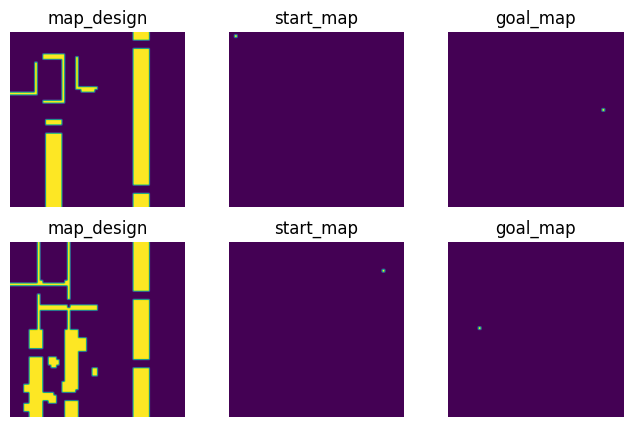

In [2]:
import matplotlib.pyplot as plt
from neural_astar.utils.data import create_dataloader
from torch.utils.data import DataLoader
from data.hmaps import GridData
# dataloader = create_dataloader("./planning-datasets/data/mpd/mazes_032_moore_c8.npz", "test", 8)
test_data = GridData(
        path='./TransPath_data/test'
)
dataloader = DataLoader(test_data, batch_size=10,
                        shuffle=False, num_workers=0, pin_memory=True)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))

fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")

Then, search can be performed by simply forwarding the model. The output is namedtuple `AstarOutput` with `histories` (search history maps) and `paths` (path maps).

/home/dan/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 529.5, 133.5, -0.5)

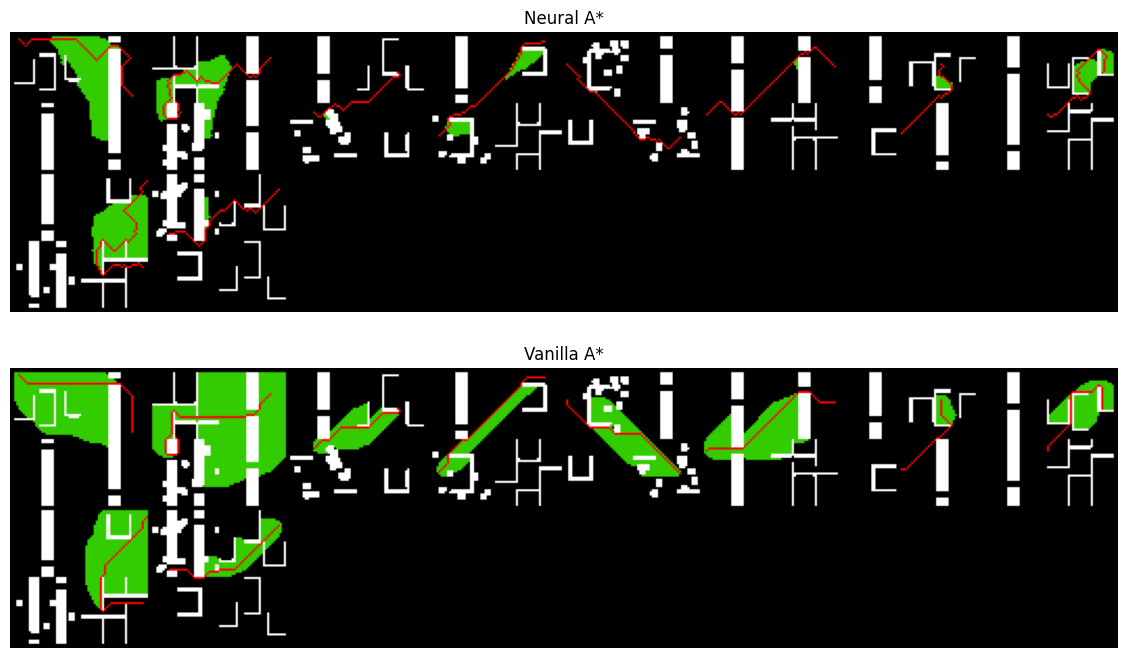

In [3]:
from neural_astar.utils.data import visualize_results

neural_astar.eval()
na_outputs = neural_astar(((map_designs == 0)*1.).to(device), start_maps.to(device), goal_maps.to(device))
vanilla_astar.eval()
va_outputs = vanilla_astar(((map_designs == 0)*1.).to(device), start_maps.to(device), goal_maps.to(device), ((map_designs == 0)*1.).to(device))

fig, axes = plt.subplots(2, 1, figsize=[20, 8])
axes[0].imshow(visualize_results(map_designs, na_outputs))
axes[0].set_title("Neural A*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, va_outputs))
axes[1].set_title("Vanilla A*")
axes[1].axis("off")


In [4]:
hardness_limit =  1.05
expansions_ratio = []
cost_ratio = []
hardness = []

for i, batch in enumerate(dataloader):
    with torch.no_grad():
        map_design, start, goal, gt_heatmap = batch
        # inputs = torch.cat([map_design, start + goal], dim=1) if mode == 'f' else torch.cat([map_design, goal], dim=1)
        # inputs = inputs.to(device)

       
        learn_outputs = neural_astar(
            ((map_design == 0)*1.).to(device),
            start.to(device),
            goal.to(device),
            store_intermediate_results = True
        )

        vanilla_outputs = vanilla_astar(
            ((map_design == 0)*1.).to(device),
            start.to(device),
            goal.to(device),
            ((map_design == 0)*1.).to(device),
        )
        expansions_ratio.append(((learn_outputs.histories).sum((-1, -2, -3))) / ((vanilla_outputs.histories).sum((-1, -2, -3))))
        learn_costs = (learn_outputs.intermediate_results[-1]["g"] * goal.to(device)).sum((-1, -2, -3))
        vanilla_costs = (vanilla_outputs.g * goal.to(device)).sum((-1, -2, -3))
        cost_ratio.append(learn_costs / vanilla_costs)
        start_heur = (get_diag_heuristic(goal[:, 0].to(device)) * start[:, 0].to(device)).sum((-1, -2))
        hardness.append(vanilla_costs / start_heur)
    print( ' '*20 + f'\r{i} / {len(dataloader)} {len(expansions_ratio)} {learn_costs.sum().item()} {vanilla_costs.sum().item()} {learn_outputs.intermediate_results[-1]["g"].shape}', end='\r')



KeyboardInterrupt: 

In [14]:
hardness_limit =  1.15
# expansions_ratio = torch.cat(expansions_ratio, dim=0)
# cost_ratio = torch.cat(cost_ratio, dim=0)
# hardness = torch.cat(hardness, dim=0)
mask = torch.where(hardness >= hardness_limit, torch.ones_like(hardness), torch.zeros_like(hardness))
n = mask.sum()
print( expansions_ratio)
expansions_ratio_ = (expansions_ratio * mask).sum() / n
cost_ratio_ = (cost_ratio * mask).sum() / n

print(f'expansions_ratio: {expansions_ratio_}, cost_ratio: {cost_ratio_}')

tensor([0.6193, 0.2671, 0.1048,  ..., 0.2026, 0.1732, 0.8772], device='cuda:0')
expansions_ratio: 0.47934749722480774, cost_ratio: 1.0572298765182495


In [13]:
print(len(dataloader))

13
